# Set up

## Package Loading

In [ ]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Up paths

In [ ]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_train = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/train_tweet.csv" 
path_test = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/test_tweet.csv" 
path_proprocessed = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/text_without_sw.csv" 

path_hyperparameters_sgd = parent_path+"team project/codes/models/best parameters/sgd.csv"
path_hyperparameters_svm = parent_path+"team project/codes/models/best parameters/svm.csv"
path_hyperparameters_et = parent_path+"team project/codes/models/best parameters/et.csv"
path_hyperparameters_rf = parent_path+"team project/codes/models/best parameters/rf.csv"
path_hyperparameters_nb = parent_path+"team project/codes/models/best parameters/nb.csv"
path_hyperparameters_knn = parent_path+"team project/codes/models/best parameters/knn.csv"
path_hyperparameters_lr = parent_path+"team project/codes/models/best parameters/lr.csv"
path_hyperparameters_dt = parent_path+"team project/codes/models/best parameters/dt.csv"

path_best_parameters_sgd = parent_path+"team project/codes/models/sgd.pkl"
path_best_parameters_svm = parent_path+"team project/codes/models/svm.pkl"
path_best_parameters_et = parent_path+"team project/codes/models/et.pkl"
path_best_parameters_rf = parent_path+"team project/codes/models/rf.pkl"
path_best_parameters_nb = parent_path+"team project/codes/models/nb.pkl"
path_best_parameters_knn = parent_path+"team project/codes/models/knn.pkl"
path_best_parameters_lr = parent_path+"team project/codes/models/lr.pkl"
path_best_parameters_dt = parent_path+"team project/codes/models/dt.pkl"

## Set Up Functions

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Balance Dataset

In [ ]:
# loading preprocessd data
df = pd.read_csv(path_proprocessed)
df = df[df['text'].apply(lambda x: isinstance(x, str))] # Temporal solution

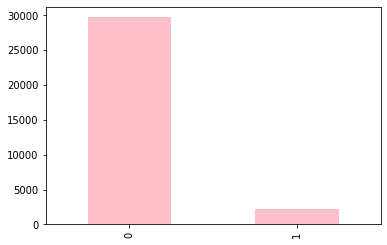

In [ ]:
df['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

## Train, Validation, Test Split

In [ ]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
x_train = x_train['text']
#del x_train['label']

y_test = x_test['label']
x_test = x_test['text']
#del x_test['label']

y_valid = x_valid['label']
x_valid = x_valid['text']
#del x_valid['label']

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)
display(x_train)

(25559,)
(3195,)
(3195,)


626      cherry color symbol warm positive energy neckl...
3867     booked glasgow glasgow nd dec leeds rd manches...
27368                     hea calm amp smile genuine smile
13413               user hoping bullseye archery user user
4933     found bourbon street absolutely crazy nola bou...
                               ...                        
15124    wow followed us last week since launched overw...
27542    user trump new york co chair makes racist gori...
24576                 thankful apologies thankful positive
27976            would awesome whaaaaaa hahahaha user user
11831    competing threads hate orlando club shooting a...
Name: text, Length: 25559, dtype: object

# Training Models in a Pipeline

## Pipeline Set Up

In [ ]:
# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
f1 = make_scorer(f1_score)

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


## Naïve Bayes

In [ ]:
# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 359.3957121372223 seconds ---
Multinomial NBClassifier: 47.31251103681801% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 1, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': True}


['/content/drive/My Drive/team project/codes/models/nb.pkl']

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2971
           1       0.30      0.89      0.45       224

    accuracy                           0.85      3195
   macro avg       0.65      0.87      0.68      3195
weighted avg       0.94      0.85      0.88      3195



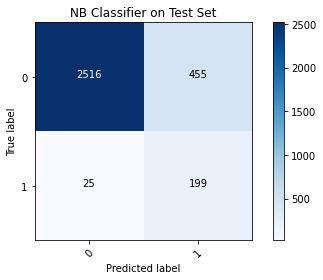

In [ ]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))

## KNN

In [ ]:
# Optimize parameters for KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__n_neighbors': [5, 10, 15, 20, 25],
    'estimator__weights': ['uniform','distance'],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
       }

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("KNN : {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_knn, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_knn, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', KNeighborsClassifier())])
Fitting 8 folds for each of 960 candidates, totalling 7680 fits
--- 3711.2523951530457 seconds ---
KNN : 45.52498185215394% F1-score for class 'hate-speech' with parameters {'estimator__algorithm': 'auto', 'estimator__n_neighbors': 10, 'estimator__weights': 'uniform', 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': True}


['/content/drive/My Drive/team project/codes/models/knn.pkl']

              precision    recall  f1-score   support

           0       0.98      0.82      0.90      2971
           1       0.26      0.83      0.39       224

    accuracy                           0.82      3195
   macro avg       0.62      0.82      0.64      3195
weighted avg       0.93      0.82      0.86      3195



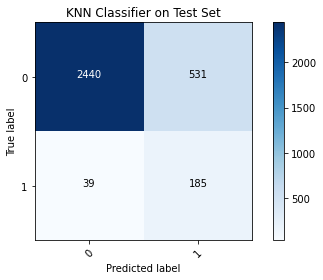

In [ ]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "KNN Classifier on Test Set")
print(classification_report(y_test, prediction))

## Random Forest

In [ ]:
# Optimize parameters for Random Forest
estimator = RandomForestClassifier( random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__criterion': ['gini', ' entropy'],
    'estimator__n_estimators': [100, 300, 500, 800],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Random Forest Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_rf, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_rf, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', RandomForestClassifier(random_state=42))])
Fitting 8 folds for each of 5184 candidates, totalling 41472 fits


/home/v.zevallosm/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.4639124  0.46547152 0.46023681 ...        nan        nan        nan]
  category=UserWarning


--- 2344.0287425518036 seconds ---
Random Forest Classifier: 53.37193506504465% F1-score for class 'hate-speech' with parameters {'estimator__criterion': 'gini', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 800, 'vectorizer__max_df': 0.25, 'vectorizer__norm': None, 'vectorizer__smooth_idf': True}


['/home/v.zevallosm/team project/codes/models/rf.pkl']

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2971
           1       0.41      0.71      0.52       224

    accuracy                           0.91      3195
   macro avg       0.69      0.81      0.73      3195
weighted avg       0.94      0.91      0.92      3195



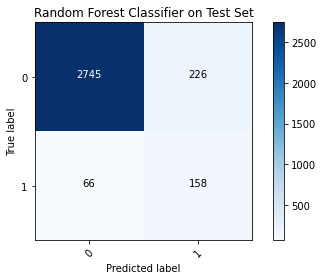

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Random Forest Classifier on Test Set")
print(classification_report(y_test, prediction))


## Extra Trees

In [ ]:
# Optimize parameters for Extra Trees
estimator = ExtraTreesClassifier( random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__criterion': ['gini', ' entropy'],
    'estimator__n_estimators': [100, 300, 500, 800],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Extra Trees Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_et, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_et, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', ExtraTreesClassifier(random_state=42))])
Fitting 8 folds for each of 5184 candidates, totalling 41472 fits


/home/v.zevallosm/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.45371934 0.44843191 0.46492321 ...        nan        nan        nan]
  category=UserWarning


--- 2749.808964729309 seconds ---
Extra Trees Classifier: 56.88402752771815% F1-score for class 'hate-speech' with parameters {'estimator__criterion': 'gini', 'estimator__max_depth': 15, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 800, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/home/v.zevallosm/team project/codes/models/et.pkl']

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2971
           1       0.50      0.69      0.58       224

    accuracy                           0.93      3195
   macro avg       0.74      0.82      0.77      3195
weighted avg       0.94      0.93      0.94      3195



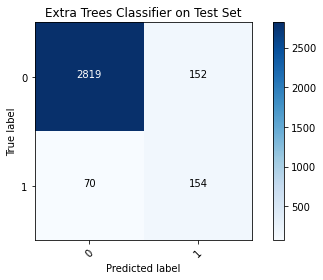

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Extra Trees Classifier on Test Set")
print(classification_report(y_test, prediction))


## SGD

In [ ]:
# Optimize parameters for SGDClassifier
estimator = SGDClassifier(max_iter=5000, random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge','modified_huber','perceptron','squared_hinge'],
    'estimator__alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'estimator__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("SGDClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_sgd, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_sgd, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', SGDClassifier(max_iter=5000, random_state=42))])
Fitting 8 folds for each of 4608 candidates, totalling 36864 fits
--- 11506.218701601028 seconds ---
SGDClassifier: 58.36113514801878% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 0.001, 'estimator__loss': 'hinge', 'estimator__tol': 0.01, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/sgd.pkl']

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2971
           1       0.47      0.75      0.57       224

    accuracy                           0.92      3195
   macro avg       0.72      0.84      0.77      3195
weighted avg       0.94      0.92      0.93      3195



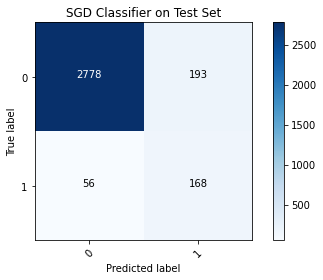

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "SGD Classifier on Test Set")
print(classification_report(y_test, prediction))


## SVM

In [ ]:
# Optimize parameters for LSVM Classifier
estimator = LinearSVC(max_iter=5000, random_state=42, dual = True)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge', 'squared_hinge'],
    'estimator__tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("LSVM Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_svm, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_svm, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', LinearSVC(max_iter=5000, random_state=42))])
Fitting 8 folds for each of 1680 candidates, totalling 13440 fits
--- 6578.054311037064 seconds ---
LSVM Classifier: 59.11648971569943% F1-score for class 'hate-speech' with parameters {'estimator__C': 0.1, 'estimator__loss': 'hinge', 'estimator__tol': 0.001, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/svm.pkl']

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2971
           1       0.57      0.60      0.59       224

    accuracy                           0.94      3195
   macro avg       0.77      0.78      0.78      3195
weighted avg       0.94      0.94      0.94      3195



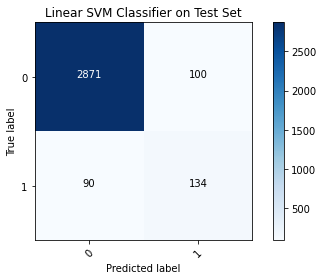

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Linear SVM Classifier on Test Set")
print(classification_report(y_test, prediction))


## Logistic Regression

In [ ]:
# Optimize parameters for Logistic Regression
estimator = LogisticRegression()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__penalty': [ 'l2', 'none'],
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'estimator__C': [100, 10, 1.0, 0.1, 0.01]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Logistic Regression Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_lr, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_lr, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', LogisticRegression())])
Fitting 8 folds for each of 1200 candidates, totalling 9600 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
960 fits failed out of a total of 9600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

--- 3418.477582216263 seconds ---
Logistic Regression Classifier: 56.512767626947344% F1-score for class 'hate-speech' with parameters {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'newton-cg', 'vectorizer__max_df': 0.25, 'vectorizer__norm': None, 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/lr.pkl']

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2971
           1       0.41      0.79      0.54       224

    accuracy                           0.91      3195
   macro avg       0.70      0.85      0.75      3195
weighted avg       0.94      0.91      0.92      3195



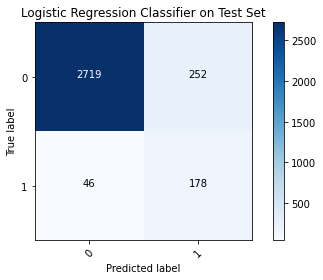

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Logistic Regression Classifier on Test Set")
print(classification_report(y_test, prediction))

## Decision Tree

In [ ]:
# Optimize parameters for simple Decision Tree
estimator = DecisionTreeClassifier(random_state=101)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.3, 0.6, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__splitter' : ['best', 'random'],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Decision Tree Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_dt, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_dt, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', DecisionTreeClassifier(random_state=101))])
Fitting 8 folds for each of 972 candidates, totalling 7776 fits
--- 2684.384980916977 seconds ---
Decision Tree Classifier: 47.275311076294436% F1-score for class 'hate-speech' with parameters {'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 25, 'estimator__splitter': 'best', 'vectorizer__max_df': 0.3, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/team project/codes/models/dt.pkl']

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2971
           1       0.41      0.50      0.45       224

    accuracy                           0.91      3195
   macro avg       0.69      0.72      0.70      3195
weighted avg       0.92      0.91      0.92      3195



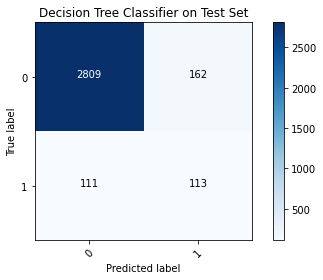

In [ ]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Decision Tree Classifier on Test Set")
print(classification_report(y_test, prediction))